In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from collections import defaultdict
import argparse
import cv2  # NOQA (Must import before importing caffe2 due to bug in cv2)
import numpy as np
import glob
import logging
import os
import sys
import time

from caffe2.python import workspace

from detectron.core.config import assert_and_infer_cfg
from detectron.core.config import cfg
from detectron.core.config import merge_cfg_from_file
from detectron.utils.io import cache_url
from detectron.utils.logging import setup_logging
from detectron.utils.timer import Timer
import detectron.core.test_engine as infer_engine
import detectron.datasets.dummy_datasets as dummy_datasets
import detectron.utils.c2 as c2_utils
# import detectron.utils.vis as vis_utils

c2_utils.import_detectron_ops()

# OpenCL may be enabled by default in OpenCV3; disable it because it's not
# thread safe and causes unwanted GPU memory allocations.
cv2.ocl.setUseOpenCL(False)

import easydict

Found Detectron ops lib: /pytorch/build/lib/libcaffe2_detectron_ops_gpu.so


In [2]:
import os
from os.path import join
# cwd = os.getcwd()
# print('cwd:',cwd)
cwd='/Detectron'
sys.path.insert(0,cwd)


In [3]:
wts='doutput2/train/keypoints_coco_2014_train:keypoints_coco_2014_valminusminival/generalized_rcnn/model_final.pkl'
args = easydict.EasyDict({
    "cfg": join(cwd,'configs/12_2017_baselines/e2e_mask_and_keypoint_rcnn_R-50-FPN_1x.yaml'),
    "weights": join(cwd,wts),
    "output_dir": '/datasets/data/2014/heidi_test/detectron_test',
    "image_ext": 'jpg',
    "out_when_no_box": 'store_true',
    "output_ext": 'png', 
    "thresh": 0.7,
    "kp_thresh": 2.0,
    "im_or_folder": '/datasets/data/2014/heidi_test/demo',
 
})



In [4]:
merge_cfg_from_file(args.cfg)

In [5]:

cfg.NUM_GPUS = 1
args.weights = cache_url(args.weights, cfg.DOWNLOAD_CACHE)
assert_and_infer_cfg(cache_urls=False)

In [6]:
model = infer_engine.initialize_model_from_cfg(args.weights)
dummy_coco_dataset = dummy_datasets.get_coco_dataset()

INFO:detectron.utils.net:Loading weights from: /Detectron/doutput2/train/keypoints_coco_2014_train:keypoints_coco_2014_valminusminival/generalized_rcnn/model_final.pkl
INFO:detectron.utils.net:conv1_w loaded from weights file into gpu_0/conv1_w: (64, 3, 7, 7)





 src_blobs: <type 'dict'>


INFO:detectron.utils.net:res_conv1_bn_s loaded from weights file into gpu_0/res_conv1_bn_s: (64,)
INFO:detectron.utils.net:res_conv1_bn_b loaded from weights file into gpu_0/res_conv1_bn_b: (64,)
INFO:detectron.utils.net:res2_0_branch2a_w loaded from weights file into gpu_0/res2_0_branch2a_w: (64, 64, 1, 1)
INFO:detectron.utils.net:res2_0_branch2a_bn_s loaded from weights file into gpu_0/res2_0_branch2a_bn_s: (64,)
INFO:detectron.utils.net:res2_0_branch2a_bn_b loaded from weights file into gpu_0/res2_0_branch2a_bn_b: (64,)
INFO:detectron.utils.net:res2_0_branch2b_w loaded from weights file into gpu_0/res2_0_branch2b_w: (64, 64, 3, 3)
INFO:detectron.utils.net:res2_0_branch2b_bn_s loaded from weights file into gpu_0/res2_0_branch2b_bn_s: (64,)
INFO:detectron.utils.net:res2_0_branch2b_bn_b loaded from weights file into gpu_0/res2_0_branch2b_bn_b: (64,)
INFO:detectron.utils.net:res2_0_branch2c_w loaded from weights file into gpu_0/res2_0_branch2c_w: (256, 64, 1, 1)
INFO:detectron.utils.net

In [7]:
if os.path.isdir(args.im_or_folder):
    print('folder')
    #im_list = glob.iglob(args.im_or_folder + '/*.' + args.image_ext)
    im_list = glob.glob(args.im_or_folder + '/*.' + args.image_ext)
else:
    print('img list')
    im_list = [args.im_or_folder]
    
print('im_list:',im_list)

folder
im_list: [u'/datasets/data/2014/heidi_test/demo/p02.jpg', u'/datasets/data/2014/heidi_test/demo/p01.jpg', u'/datasets/data/2014/heidi_test/demo/p03.jpg']


In [8]:
def get_body_part(p_img, kps,bbox=(0,0,100,200), kp_thresh=2):
    

    
    cut_list = [[1,2],[0,3,4],[5,6],[7,8],[20],[11,12],[13,14],[15,16]]
    
    
    top_key=99999
    top_key_idx=-1
    head_p =-1
    sh_p=-1
    
    for k in range(17):    
        if kps[2, k] > kp_thresh:
            if k in [0,3,4] and head_p<0:
                head_p=int(kps[1, k])
                
            if k in [5,6] and sh_p<0:
                sh_p=int(kps[1, k])
            
            key_y= int(kps[1, k])
            top_key = min(top_key, key_y)
            if top_key==key_y:
                top_key_idx=k
               
    if head_p<0 or sh_p<0 or top_key_idx<0:
        return p_img.astype(np.uint8), False
    
    head_sh_len = abs(sh_p-head_p)
    ph,pw,pch = p_img.shape
    w=pw
    h=int(head_sh_len*9) if int(head_sh_len*9) >int(ph) else int(ph)
    part_h = int(h/9)
    
    zerobox=np.zeros((h,w,3))
    #print(zerobox.shape)
                
    #print('bottom_key_idx:',top_key_idx)
    for i in range(0,len(cut_list)):
        if top_key_idx in cut_list[i]:
            start_top=part_h*i

            #print('start_top:',i,start_top)
            zerobox[start_top:start_top+ph,:,:]=p_img[:,:,:]
            break
            
    return zerobox.astype(np.uint8), True

In [9]:

import cv2
import numpy as np
import os

import pycocotools.mask as mask_util

from detectron.utils.colormap import colormap
import detectron.utils.env as envu
import detectron.utils.keypoints as keypoint_utils

# Matplotlib requires certain adjustments in some environments
# Must happen before importing matplotlib
envu.set_up_matplotlib()
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

plt.rcParams['pdf.fonttype'] = 42  # For editing in Adobe Illustrator

def convert_from_cls_format(cls_boxes, cls_segms, cls_keyps):
    """Convert from the class boxes/segms/keyps format generated by the testing
    code.
    """
    box_list = [b for b in cls_boxes if len(b) > 0]
    if len(box_list) > 0:
        boxes = np.concatenate(box_list)
    else:
        boxes = None
    if cls_segms is not None:
        segms = [s for slist in cls_segms for s in slist]
    else:
        segms = None
    if cls_keyps is not None:
        keyps = [k for klist in cls_keyps for k in klist]
    else:
        keyps = None
    classes = []
    for j in range(len(cls_boxes)):
        classes += [j] * len(cls_boxes[j])
    return boxes, segms, keyps, classes

def vis_mask_v2(img, mask, col, alpha=1.0, show_border=True, border_thick=1):
    """Visualizes a single binary mask."""

    zero_img = np.zeros_like(img).astype(np.float32)
    #img = img.astype(np.float32)
    idx = np.nonzero(mask)

    zero_img[idx[0], idx[1], :] *= 0 #1.0 - alpha
    zero_img[idx[0], idx[1], :] += (255,255,255)#alpha * col

    return zero_img.astype(np.uint8)


def vis_keypoints_v2(img, kps, kp_thresh=2, alpha=0.7):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    dataset_keypoints, _ = keypoint_utils.get_keypoints()
    kp_lines = kp_connections(dataset_keypoints)

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)

    # Draw the keypoints.
    for l in range(17):
        
        p3 = kps[0, l], kps[1, l]
        cv2.putText(img, str(l), (p3), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2)
        

    # Blend the keypoints.
    return img #cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)



def vis_one_image_opencv_heidi(
        im, boxes, segms=None, keypoints=None, thresh=0.9, kp_thresh=2,
        show_box=False, dataset=None, show_class=False):
    """Constructs a numpy array with the detections visualized."""
    my_mask = np.zeros_like(im) 
    ori_img=im.copy()
    
    bbox_list=[]
    pbox_list=[]
    if isinstance(boxes, list):
        boxes, segms, keypoints, classes = convert_from_cls_format(
            boxes, segms, keypoints)

    if boxes is None or boxes.shape[0] == 0 or max(boxes[:, 4]) < thresh:
        return im

    if segms is not None and len(segms) > 0:
        masks = mask_util.decode(segms)
        color_list = colormap()
        mask_color_id = 0

    # Display in largest to smallest order to reduce occlusion
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    sorted_inds = np.argsort(-areas)

    for i in sorted_inds:
        bbox = boxes[i, :4]
        score = boxes[i, -1]
        if score < thresh:
            continue
            
        x1,y1,x2,y2= (int(bbox[0]), int(bbox[1]), int(bbox[2]) ,int( bbox[3]))
        #print('x1,y1,x2,y2:',x1,y1,x2,y2)
        
        bbox_list.append((x1,y1,x2,y2))


        # show class (off by default)
        #print('score:',score)

        # show mask
        if segms is not None and len(segms) > i:
            color_mask = color_list[mask_color_id % len(color_list), 0:3]
            #print('color_mask:',color_mask)
            mask_color_id += 1
            
            zero_img = vis_mask_v2(ori_img, masks[..., i], color_mask)
            
            my_mask[zero_img==255]=255#ori_img[zero_img==255]

        # show keypoints
        if keypoints is not None and len(keypoints) > i:
            kps=keypoints[i]
            zerobox, zero_bool = get_body_part(ori_img[y1:y2,x1:x2,:],kps,bbox)
            
            pbox_list.append([zerobox, zero_bool])
            """
            
            for l in range(17):       
                if kps[2, l] > kp_thresh:
                    p3 = int(kps[0, l]), int(kps[1, l])
                    
                    cv2.putText(ori_img, str(l), (p3), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            """

    return ori_img, my_mask, bbox_list, pbox_list


i 0 /datasets/data/2014/heidi_test/demo/p01.jpg
pi 0 True


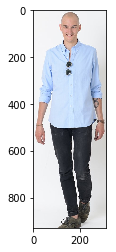

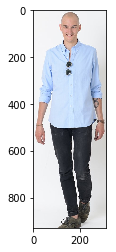

i 1 /datasets/data/2014/heidi_test/demo/p02.jpg
pi 0 True


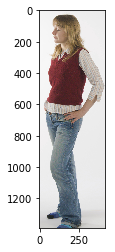

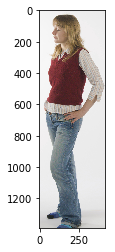

pi 1 True


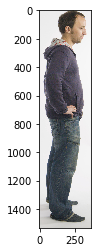

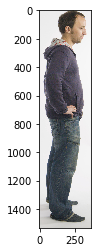

i 2 /datasets/data/2014/heidi_test/demo/p03.jpg
pi 0 True


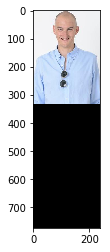

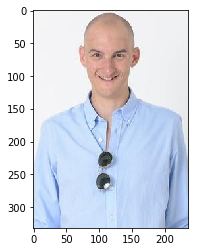

done


In [16]:
%matplotlib inline  

im_list.sort()
for i, im_name in enumerate(im_list):
    print('i',i,im_name)
    out_name = os.path.join(
        args.output_dir, '{}'.format(os.path.basename(im_name) + '.' + args.output_ext)
    )
    im = cv2.imread(im_name)
    timers = defaultdict(Timer)
    t = time.time()
    with c2_utils.NamedCudaScope(0):
        cls_boxes, cls_segms, cls_keyps = infer_engine.im_detect_all(
            model, im, None, timers=timers
        )

    ori_img, my_mask, bbox_list, pbox_list =vis_one_image_opencv_heidi(
        im[:, :, ::-1],  # BGR -> RGB for visualization
        cls_boxes,
        cls_segms,
        cls_keyps,
        thresh=args.thresh,
        kp_thresh=args.kp_thresh,
        show_box=True)

    for pi,p in enumerate(pbox_list):
        print('pi',pi,p[1])
        if p[1]==True:
            plt.imshow(p[0])
            plt.show()
            bbox=bbox_list[pi]
            x1,y1,x2,y2=bbox
            
            plt.imshow(ori_img[y1:y2,x1:x2,:])
            plt.show()
print('done')

---

In [1]:
import os
import sys

ROOT_DIR = "/datasets/data/2014/heidi_test/rt-mrcnn"#os.path.abspath("./")
print(ROOT_DIR)
sys.path.append(ROOT_DIR)

/datasets/data/2014/heidi_test/rt-mrcnn


In [2]:
ROOT_DIR2="datasets/data/2014/heidi_test/rt-mrcnn/mrcnn"
print(ROOT_DIR2)
sys.path.append(ROOT_DIR2)

datasets/data/2014/heidi_test/rt-mrcnn/mrcnn


In [3]:
import cv2
import time
import imutils
import numpy as np
import mrcnn.model as modellib
from mrcnn import utils, visualize
from imutils.video import WebcamVideoStream
import random
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
W0807 08:35:00.050224 140019269121792 deprecation_wrapper.py:119] From /datasets/data/2014/heidi_test/rt-mrcnn/mrcnn/model.py:22: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0807 08:35:00.050540 140019269121792 deprecation_wrapper.py:119] From /datasets/data/2014/heidi_test/rt-mrcnn/mrcnn/model.py:25: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



('config.gpu_options.per_process_gpu_memory_fraction:', 0.7)


ImportError: No module named request

In [ ]:

# Root directory of the project
from samples.coco.coco import CocoConfig

#ROOT_DIR = os.path.abspath("./")

sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

class InferenceConfig(CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)
print('load model: ',COCO_MODEL_PATH)

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

colors = visualize.random_colors(len(class_names))

gentle_grey = (45, 65, 79)
white = (255, 255, 255)

OPTIMIZE_CAM = False
SHOW_FPS = False
SHOW_FPS_WO_COUNTER = True # faster
PROCESS_IMG = True